# Predicting Power Prices in Spain - Group 3
The provided datasets contain the following timeseries with hourly granularity:
* date: date of the observation ”%Y-%m-%d”
* hour: hour of the observation, [0 - 23]
* fc demand: forecast of demand in MWh
* fc nuclear: forecast of nuclear power production in MWh
* import FR: forecast of the importing capacity from France to Spain in MWh
* export FR: forecast of the exporting capacity from Spain to France in MWh
* fc wind: forecast of wind power production in MWh
* fc solar pv: forecast of PV solar (solar panels) power production in MWh
* fc solar th: forecast of thermal solar power production in MWh
* price: power price for each hour in €/MWh. This is the target we want you to predict.

## 1. Environment Setup and Dataset Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MinMaxScaler, PowerTransformer, Binarizer, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, validation_curve, learning_curve, TimeSeriesSplit
import sklearn
sklearn.set_config(display="diagram")

In [2]:
#sns.__version__
#!pip install seaborn --upgrade --user

In [3]:
df = pd.read_csv('power_market.csv', parse_dates=['date'])
df.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4


## 2. Exploratory Data Analysis
### 2.1 Data types of dataset
A first view at the data types of each column proves useful in later analyses.

In [4]:
df.dtypes

fc_demand             float64
fc_nuclear            float64
import_FR             float64
export_FR             float64
fc_wind               float64
fc_solar_pv           float64
fc_solar_th           float64
price                 float64
date           datetime64[ns]
hour                    int64
dtype: object

### 2.2 Missing values in each column
Now, to examine the amount of missing values in each column.

In [5]:
len(df)

32135

In [6]:
df.isnull().sum()

fc_demand       0
fc_nuclear      0
import_FR      13
export_FR      13
fc_wind         0
fc_solar_pv     0
fc_solar_th     0
price           0
date            0
hour            0
dtype: int64

There is a suprisingly low number of missing values in the dataset. Let's see if they occur at the same time.

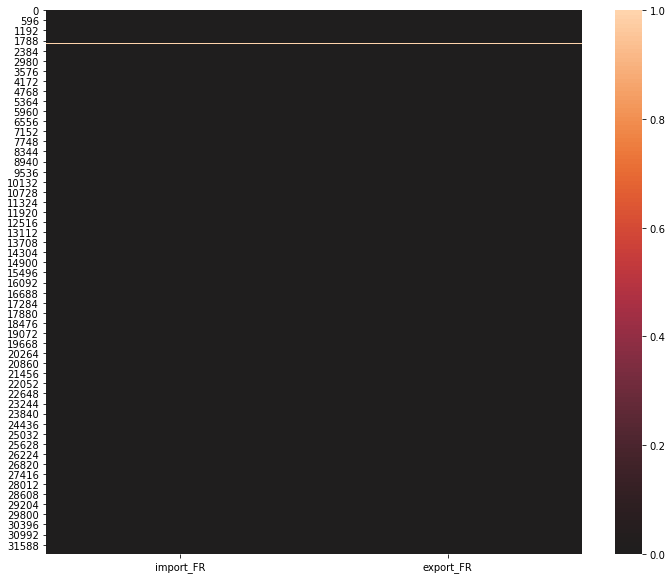

In [7]:
fig, ax = plt.subplots(figsize=(12, 10))
nan_mat = sns.heatmap(df[['import_FR', 'export_FR']].isna(), ax=ax, center=0)

At a first glance, we see that the forecasts of the importing and exporting capacities from France to Spain are missing for the same periods of time. Let's take a look at when this happens.

In [8]:
df.loc[df['export_FR'].isna(), ['date', 'hour']]

,date,hour
840,2017-02-05,0
1992,2017-03-25,0
4847,2017-07-22,0
6863,2017-10-14,0
6887,2017-10-15,0
10560,2018-03-17,0
11303,2018-04-17,0
15599,2018-10-13,0
15623,2018-10-14,0
19464,2019-03-23,0


### 2.3 Distribution of each Feature
The dataset is further explored by looking at the distribution of each column in the dataset.
#### 2.3.1 Date column
Starting with the date column:

In [9]:
print(df['date'].min(), df['date'].max())

2017-01-01 00:00:00 2020-08-31 00:00:00


In [10]:
df['date'].nunique()

1339

In [11]:
count_by_date = df[['date', 'hour']].groupby(['date']).count()
count_by_date.loc[(count_by_date != 24)['hour'], :].sort_values(by='hour')

,hour
date,
2017-03-26,23
2018-03-25,23
2019-03-31,23
2020-03-29,23
2017-10-29,25
2018-10-28,25
2019-10-27,25


For this essential column, we can see the following:
* The dataset describes 1339 days, spanning from 2017-01-01 to 2020-08-31.
* There are 3 days with more than 24 hours recorded, and 4 with less than 24 recorded hours. This is probably due to the light-saving time changes.

#### 2.3.2 Hour column
The expected distribution of the hour is fairly uniform. Let's corroborate this.

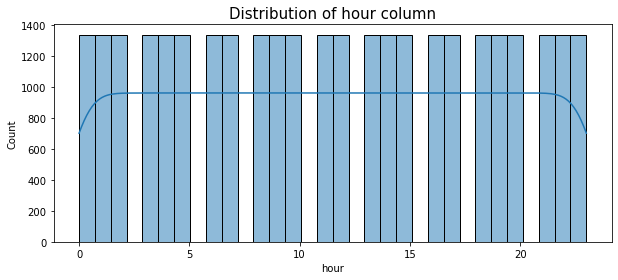

In [12]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title('Distribution of hour column', fontsize=15)
sns.histplot(df['hour'], ax=ax, kde=True)
plt.show()

#### 2.3.3 More Relevant Numerical Features
Now let's take a look at where the meat of the dataset is.

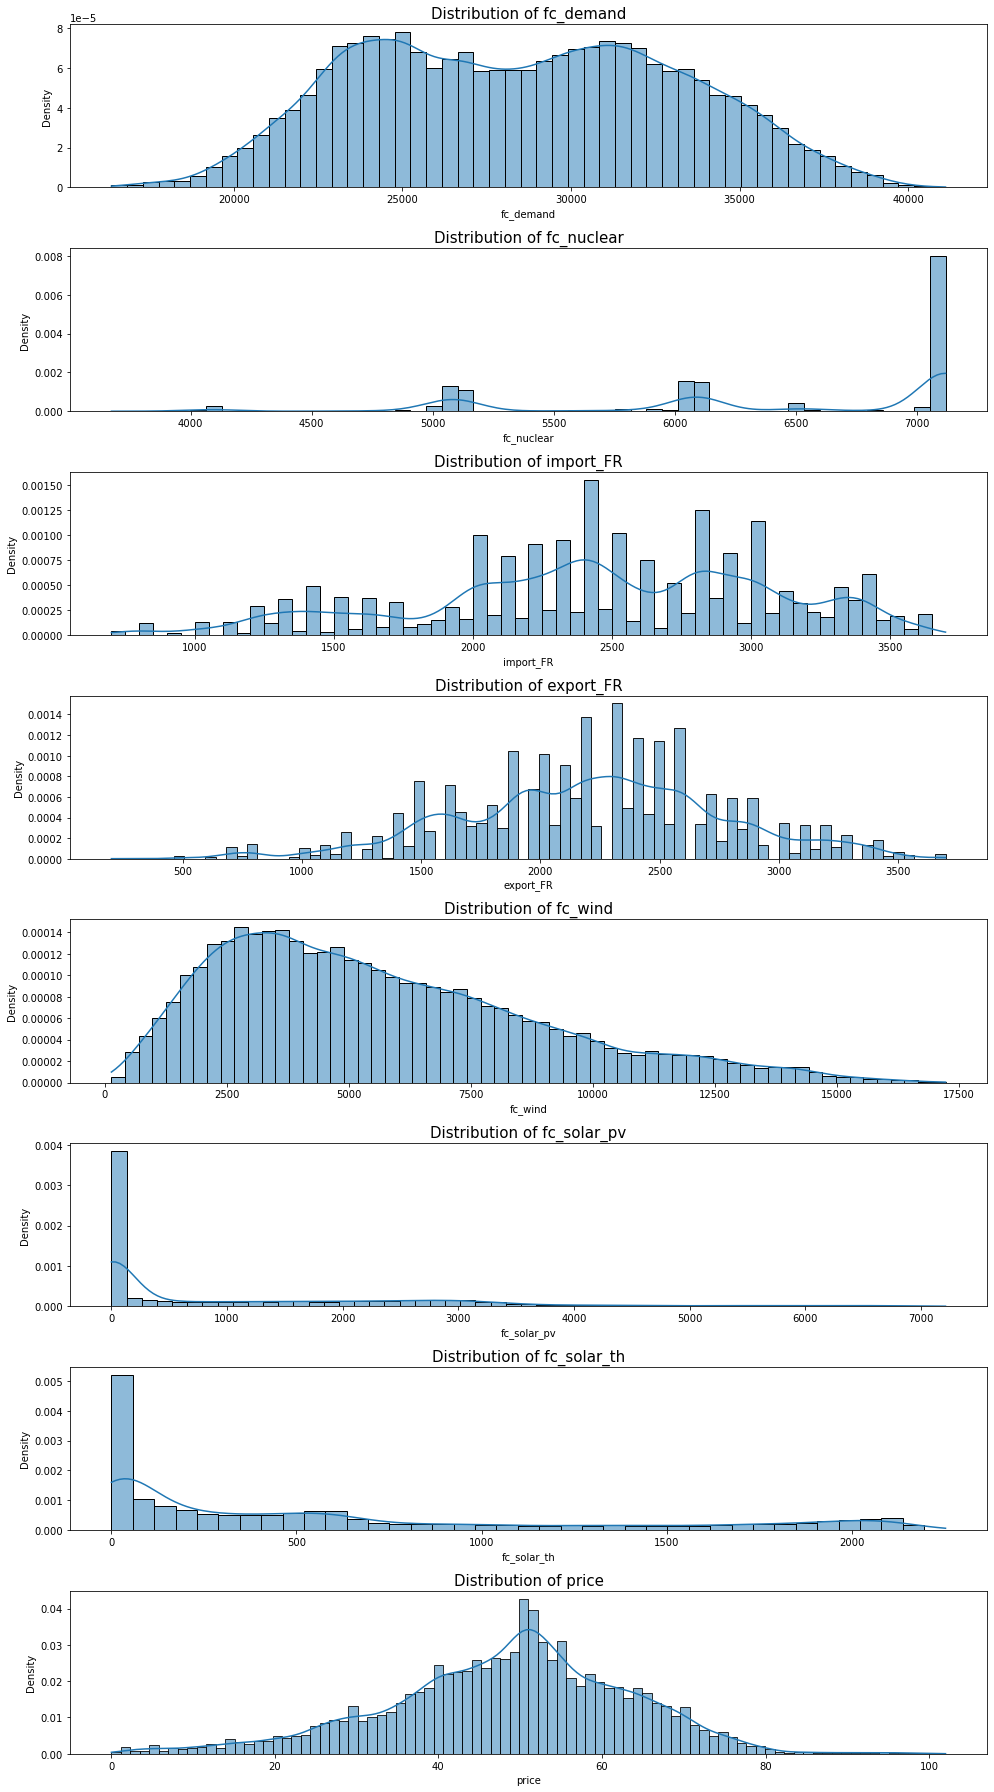

In [13]:
fields = ['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind', 'fc_solar_pv', 'fc_solar_th', 'price']
fig, axs = plt.subplots(figsize=(14, 25), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    sns.histplot(df[field], ax=ax, kde=True, stat='density')
fig.tight_layout()

The following insights can be extracted from these distributions:
* **fc_demand:** There are two peaks in the distribution, possibly showing two "modes" of consumption. Under certain conditions, the demand is more similar to the lower peak, whereas under a different configuration, demand tends towards the larger peak. This should be further studied.
* **fc_nuclear:** This distribution adds almost no value, since there around 5 clear modes. The vast majority of the dataset appears for `fc_nuclear = 7000`, whereas other much minoritary modes also exist. It may make sense to transform this variable into a categorical one with 5 categories.
* **export_FR and import_FR:** These two variables show relatively similar distributions, in the sense that they have an irregular density, are largely spread out, and are not particularly skewed.
* **fc_wind:** This variable is significantly right-skewed, sure needing some sort of Box-Cox normalization later on.
* **fc_solar_pv and fc_solar_th:** The great majority of time, these two variables are 0. It may make sense to categorize them to 0 when the numerical variable is 0, and to 1 when it is not.
* **price:** The dataset's target has a significant peak at 50€/MWh, without any significant skewness.

#### 2.3.1 A closer look at 'fc_demand'
Let's try to find the two modes in demand, based on a split in season.

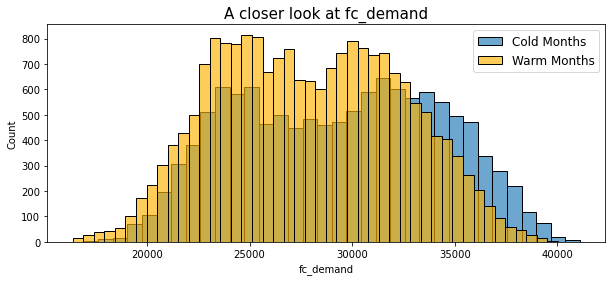

In [14]:
cold_months = df['date'].dt.month.isin([10, 11, 12, 1, 2])
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("A closer look at fc_demand", fontsize=15)
sns.histplot(df.loc[cold_months, 'fc_demand'], ax=ax, kde=False, stat='count', alpha=0.65, label='Cold Months')
sns.histplot(df.loc[~cold_months, 'fc_demand'], ax=ax, kde=False, stat='count', alpha=0.65, color='#fcb100', label='Warm Months')
ax.legend(fontsize=12)
plt.show()

Apparently it's not the season that differentiates these two modes of consumption. Perhaps it is the hour.

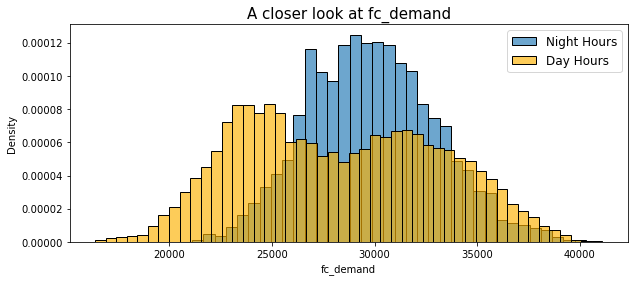

In [15]:
night_hours = df['hour'].isin([21, 22, 23] + [range(0, 8)])
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("A closer look at fc_demand", fontsize=15)
sns.histplot(df.loc[night_hours, 'fc_demand'], ax=ax, kde=False, stat='density', alpha=0.65, label='Night Hours')
sns.histplot(df.loc[~night_hours, 'fc_demand'], ax=ax, kde=False, stat='density', alpha=0.65, color='#fcb100', label='Day Hours')
ax.legend(fontsize=12)
plt.show()

It appears that these two modes of energy consumption, which cause these recurring, persistent peaks in the distribution of 'fc_demand', are not caused by a simple relation defined by 'hour' or season. Further steps of this analysis might shed more light on this issue.

### 2.4 Examining Outliers
To further examine the distribution of these numerical variables, and to visualize and identify possible outlier variables, it is useful to see the Box-plot of each variable.

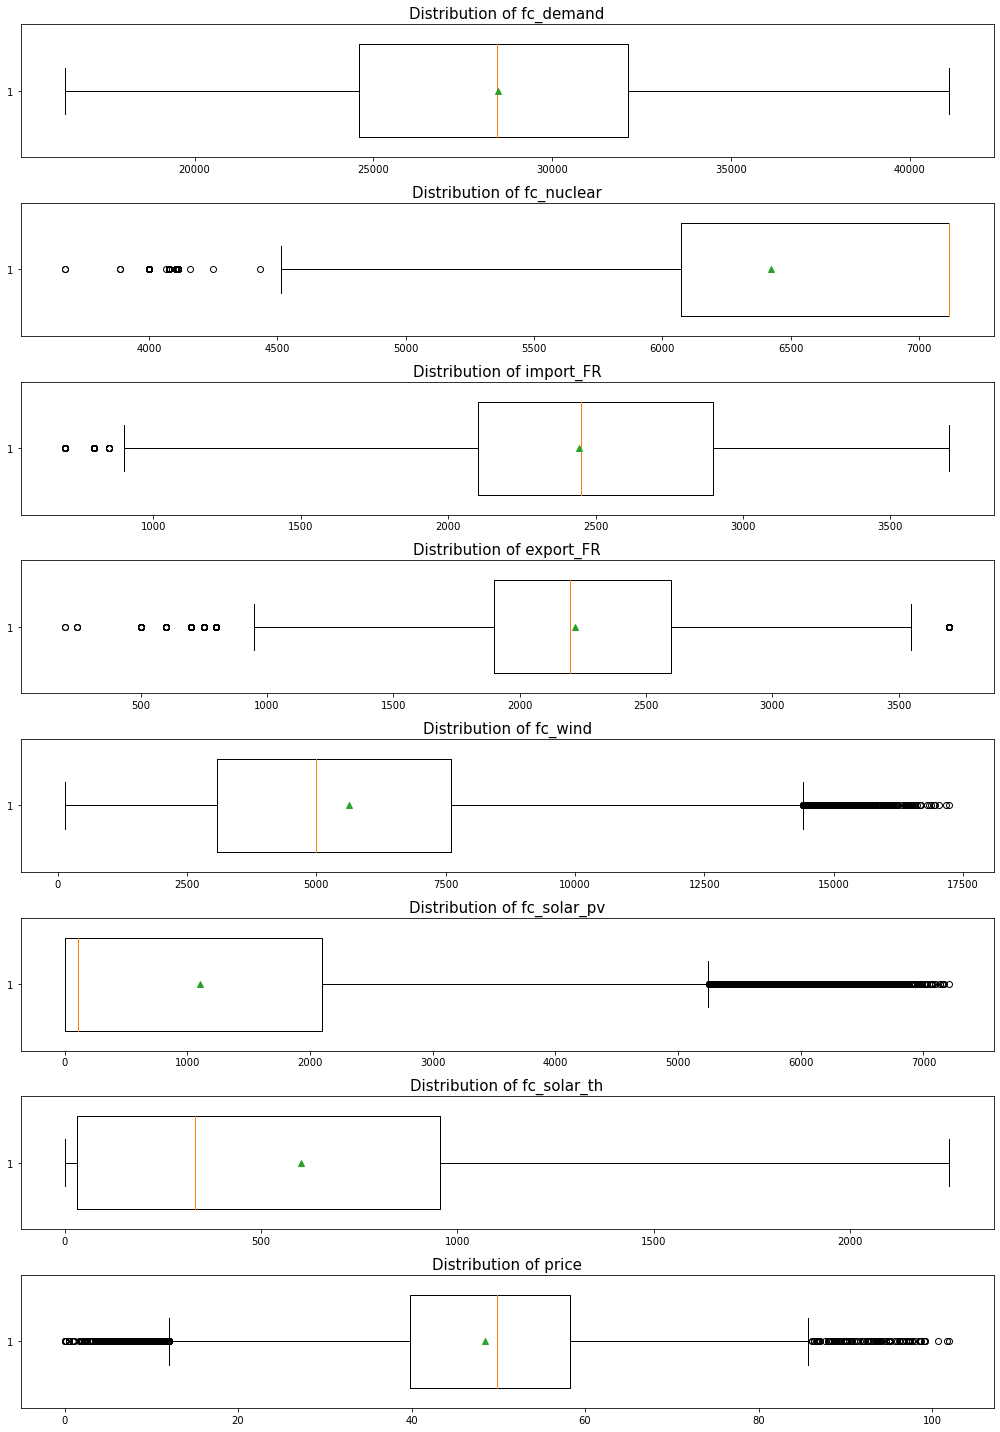

In [16]:
fields = ['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind', 'fc_solar_pv', 'fc_solar_th', 'price']
fig, axs = plt.subplots(figsize=(14, 20), ncols=1, nrows=len(fields), sharey=False)
for field, ax in zip(fields, axs):
    ax.set_title('Distribution of ' + field, fontsize=15)
    ax.boxplot(df[field].dropna().values, vert=False, widths=0.7, showmeans=True)
fig.tight_layout()

Contrasting with this second presentation of each variable's distribution, one can classify as outliers those data samples beyond $1.5 \cdot IQR$, $IQR$ being the inter-quartile range of each column. In particular:
* **fc_demand** may appear centered, but it is necessary to take the possible "two modes" of demand into account.
* **fc_nuclear** presents some outliers since its median is also its maximum value. The categorization into 5 possible modes makes sense.
* **import_FR and export_FR** are significantly spread out, but not enough to avoid some data samples being classified as outliers. Since these outliers are just a few, it may be possible to let them be.
* **fc_wind** is significantly skewed and as a result contains a large number of outliers. Perhaps a Box-Cox normalization directly ends with these outlier values.
* Whereas it still makes sense to categorize **fc_solar_pv** to 0 when the original value is 0, and 1 when it is not, the box-plot of **fc_solar_th** makes one think that it might be more sensible to normalize the variable, since the deviation of its median from its mean is not as significant.
* **price** has a large amount of outlier variables at each side. One needs to see what happens to them once the variable is normalized.

### 2.5 Correlations between Features
For determining:
* What columns affect most significantly on the target variable
* What columns present redundant information

It is useful to examine the correlation matrix of all columns in the dataframe.

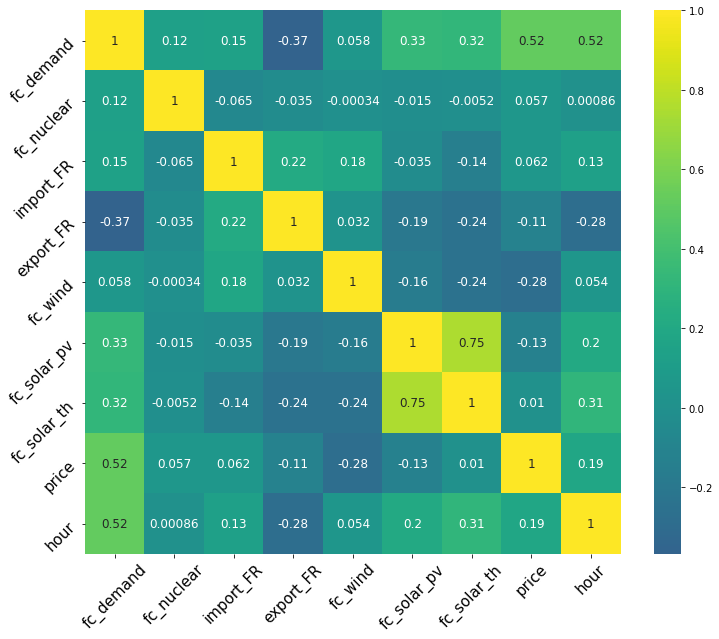

In [17]:
fig, ax = plt.subplots(figsize=(12, 10))
corr_mat = sns.heatmap(df.corr(), annot=True, cmap='viridis', ax=ax, center=0, annot_kws={"fontsize":12})
xtick_labels = corr_mat.get_xmajorticklabels()
ytick_labels = corr_mat.get_ymajorticklabels()
_ = corr_mat.set_xticklabels(xtick_labels, fontsize = 15, rotation=45)
_ = corr_mat.set_yticklabels(ytick_labels, fontsize = 15, rotation=45)

From this correlation matrix, one can extract the following:
* 'fc_demand', 'hour' are the most positively correlated columns with 'price', whereas 'fc_wind', 'export_FR', and 'fc_solar_pv' show notable negative correlations with 'price'.
* 'fc_solar_pv' and 'fc_solar_th' are very strongly correlated. Perhaps it makes sense to combine both into 'fc_solar', since both energy sources depend strongly on the amount of sunlight. However, 'fc_solar_pv' has a stronger relation with 'price' than its thermal counterpart.

Let's plot 'fc_demand', 'hour' 'fc_wind', 'export_FR', and 'fc_solar_pv' with 'price', to visualize their relationships with the target variable.

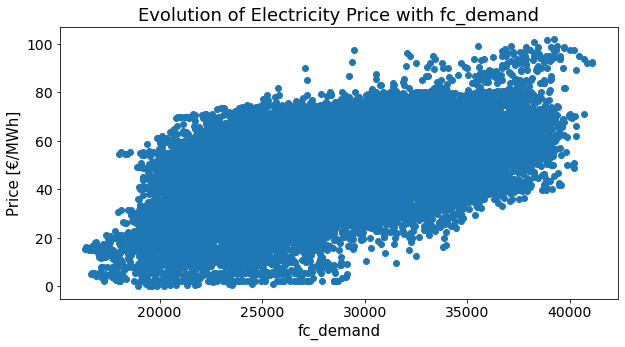

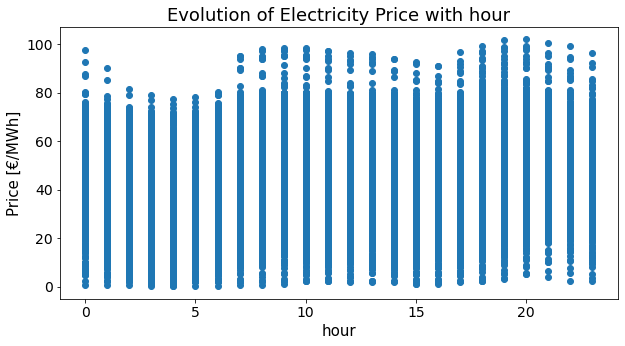

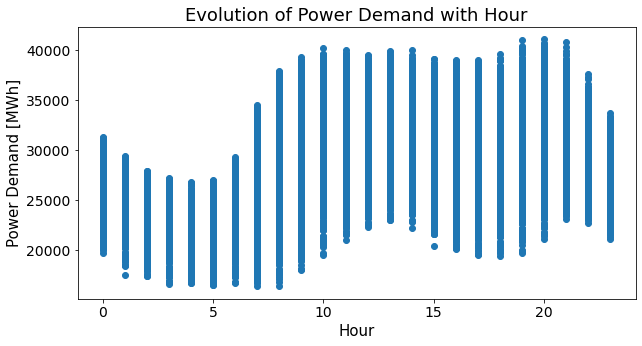

In [18]:
for x in ['fc_demand', 'hour']:
    plt.figure(figsize=(10, 5))
    plt.title('Evolution of Electricity Price with ' + x, fontsize=18)
    plt.scatter(df[x], df['price'])
    plt.xlabel(x, fontsize=15)
    plt.ylabel('Price [€/MWh]', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
plt.figure(figsize=(10, 5))
plt.title('Evolution of Power Demand with Hour', fontsize=18)
plt.scatter(df['hour'], df['fc_demand'])
plt.xlabel('Hour', fontsize=15)
plt.ylabel('Power Demand [MWh]', fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

From these three scatter plots, one can see that 'price', 'fc_demand', and 'hour' are significantly intertwined. 
* By looking at the evolution of daily demand, it is clear that power demand is much higher from 9:00 to 21:00 than it is during the rest of the day, with a peak at around 19:00. 
* On the other hand, it is clearly visible, as is expected, that demand and price are positively correlated in a straight-forward fashion.
* As a result, the evolution of electricity price with 'hour' is similar to the evolution of demand.

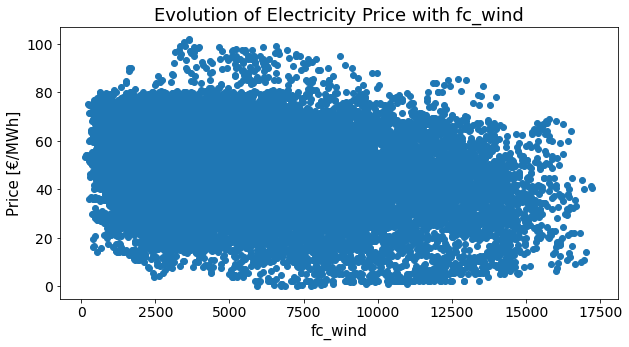

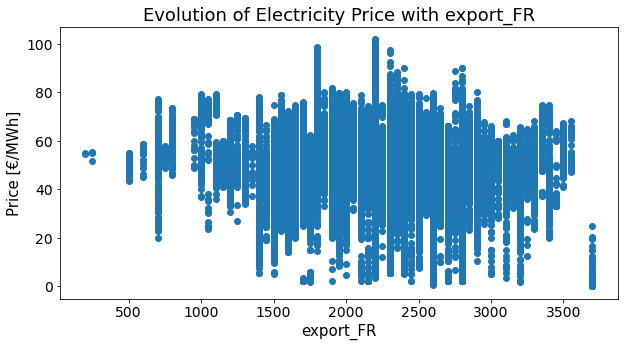

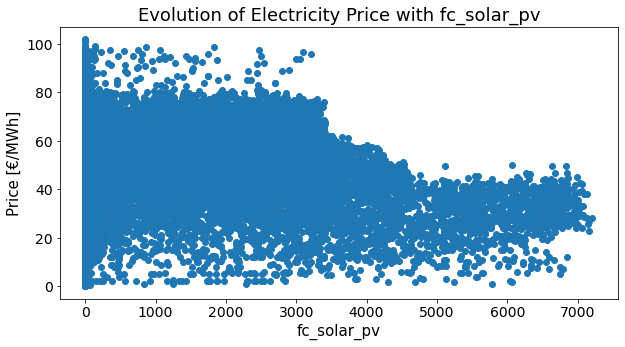

In [19]:
for x in ['fc_wind', 'export_FR', 'fc_solar_pv']:
    plt.figure(figsize=(10, 5))
    plt.title('Evolution of Electricity Price with ' + x, fontsize=18)
    plt.scatter(df[x], df['price'])
    plt.xlabel(x, fontsize=15)
    plt.ylabel('Price [€/MWh]', fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

These three last scatter plots, on the other hand, show negative correlations between the variable and 'price'.
* 'fc_solar_pv' shows the most significant negative correlation. Taking into account the distribution of the variable, where it is very frequently 0, one can see that for large values of 'fc_solar_pv', the electricity price decreases significantly.
* 'fc_wind' shows a less markedly negative correlation, perhaps because its distribution is less skewed.
* 'export_FR' does not show any signficant trend in this plot, although of these three, it has the most negative correlation.

## 3. Feature Engineering

Based on the EDA, we will perform following imputations:
* **date**: We will generate the following additional columns 
    * Month: Not used to predict but for creating other features
    * Winter: 1 if date is winter, Summer, Spring, Fall
    * Weekend: 1 if df['date'].dt.dayofweek > 5.
    * Holiday: 1 if is holiday
    
* **hour**: we will normalize hour with scikit-learn's `PowerTransformer`.     <br>**Sunlight**: We will obtain a table of dawn and sunset, and classify each hour depending on if it is during day or during night.
* **fc_demand**: Normalize with `PowerTransformer` and rescale. 
* **fc_nuclear**: We will convert this into a categorical variable, equal to 1 if fc_nuclear is close to 7000, and 0 otherwise.
* **import_FR and export_FR**: Normalize and rescale. 
* **fc_wind**: This feature is very skewed, so it definitely needs a `PowerTransformer`. See (with a boxplot) if after notmalization there are still outliers.
* **fc_solar_pv**: We will convert this to a categorical variable, equal to 0 when fc_solar_pv is close to 0, and equal to 1 otherwise.
* **fc_solar_th**: Either the same as fc_solar_pv or apply `PowerTransformer`. 
* **price**: Normalize with `PowerTransformer` or only rescale. 
* We will calculate **thermal_gap**, and ratios between demand and each production column

For each of the numerical columns, we will plot the histogram or boxplot before and after the transformation, so that the effect is clear.

### 3.1 Extracting Features from 'date' and 'hour'

#### 3.1.1 Creating a column for each season
As part of feature engineering, the first step is to extract the month for each date by using the **DatetimeIndex** method applied to the column *date* using the month condition

In [20]:
df["Month"] = pd.DatetimeIndex(df['date']).month

The second step is creating a dictionary of the seasons with respect to the months extracted in the previous step (*e.g.: Winter is represented by 1, 2, 3 which means 1st, 2nd and 3rd month of the year i.e. January, February, March*; and the same pattern follows for other seasons).

In [21]:
season_months = {"Winter": [1, 2, 3], "Spring": [4, 5, 6], "Summer": [7, 8, 9], "Fall": [10, 11, 12]}
for season in season_months.keys():
    df[season] = df["Month"].apply(lambda m: 1 if m in season_months[season] else 0)

df[[f for f in season_months.keys()]].head(10)

,Winter,Spring,Summer,Fall
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
9,1,0,0,0


#### 3.1.2 Creating a column for weekends
Extracting the days of the week and defining if the day is workday or weekend, *where the value 0 represents the first day of the week i.e. Monday, followed by remaining days.*

In [22]:
df["Day_of_Week"] = df["date"].dt.dayofweek
df["Day_of_Week"].value_counts()

0    4608
6    4607
5    4584
4    4584
3    4584
2    4584
1    4584
Name: Day_of_Week, dtype: int64

We have grouped all the Weekdays (Monday-Friday) as 0, and the Weekend (Saturday and Sunday) as 1

In [23]:
df["Weekend"] = df['Day_of_Week'].apply(lambda x: 1 if x > 4 else 0)
df["Weekend"].value_counts()

0    22944
1     9191
Name: Weekend, dtype: int64

#### 3.1.3 Creating a column for holidays
Extracting the holidays, *where the value 1 represents a holiday on that day*

In the variable spainholidays with have thus defined the dates on whcih there is an holiday in Spain. We then extract the day from the date column and concatenate it with the month of the date column and add these values to a new column daymonth.

Then, we create the column holiday where the output will be of type Boolean and return true if the value of date is present in the variable holiday defined before and then converted into integers type to be able to plot a correlation analysis further on.

The count indicates us that there are 56 true values of holidays, this gives us around 14-15 days of holidays per year, considering we have roughly 4 years data in our dataframe. 

In [24]:
spainholidays = ['1-1','6-1','9-4','10-4','1-5','2-5','15-5','15-8','12-10','1-11','2-11','9-11','6-12','7-12','8-12','25-12']
df['day']=df['date'].dt.day
df['daymonth'] = df['day'].map(str)+'-'+df['Month'].map(str)
df['Holidays'] = df['daymonth'].isin(spainholidays).astype(int)

df.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,price,date,hour,Month,Winter,Spring,Summer,Fall,Day_of_Week,Weekend,day,daymonth,Holidays
0,24400.0,7117.2,3000.0,2600.0,1732.0,0.0,5.1,58.82,2017-01-01,0,1,1,0,0,0,6,1,1,1-1,1
1,23616.0,7117.2,3000.0,2650.0,1826.0,0.0,0.6,58.23,2017-01-01,1,1,1,0,0,0,6,1,1,1-1,1
2,21893.0,7117.2,3000.0,2650.0,1823.0,0.0,4.6,51.95,2017-01-01,2,1,1,0,0,0,6,1,1,1-1,1
3,20693.0,7117.2,3000.0,2650.0,1777.0,0.0,9.7,47.27,2017-01-01,3,1,1,0,0,0,6,1,1,1-1,1
4,19599.0,7117.2,3000.0,2650.0,1746.0,0.0,24.1,45.49,2017-01-01,4,1,1,0,0,0,6,1,1,1-1,1


In [86]:
df.groupby(['Holidays'])['date'].nunique()

Holidays
0    1283
1      56
Name: date, dtype: int64

#### 3.1.4 Creating a column for daylight
In order to define this additional column, it is necessary to import data regarding the dawn and sunset hours of Madrid. In this case, a table has been created from the data in https://www.datosmundial.com/europa/espana/puesta-del-sol.php

In [26]:
sun_movements = pd.read_csv('Madrid_Sunrise_Sunset.csv',
                            header=0,
                            parse_dates=['Dawn', 'Sunset'])
sun_movements.head()

,Month,Dawn,Sunset
0,January,2021-03-08 08:34:00,2021-03-08 18:14:00
1,February,2021-03-08 08:06:00,2021-03-08 18:51:00
2,March,2021-03-08 07:24:00,2021-03-08 19:22:00
3,April,2021-03-08 07:34:00,2021-03-08 20:55:00
4,May,2021-03-08 06:56:00,2021-03-08 21:25:00


In [27]:
sun_movements['Month'] = np.arange(1, len(sun_movements) + 1)
sun_movements['Dawn'] = sun_movements['Dawn'].dt.hour
sun_movements['Sunset'] = sun_movements['Sunset'].dt.hour
sun_movements.head()

,Month,Dawn,Sunset
0,1,8,18
1,2,8,18
2,3,7,19
3,4,7,20
4,5,6,21


This data is incorporated by joining this table with the original dataset. For every value in 'hr', it is examined whether it is within the Dawn-Sunset time interval. Since light is present *before* the sun rises and *after* the sun sets, this interval includes the whole hours in which the sun rises and sets.

In [28]:
df = df.merge(sun_movements, on='Month', how='left')

In [29]:
df['Daylight'] = df[['hour', 'Dawn', 'Sunset']].apply(lambda row: 1 if (row[0] >= row[1] and row[0] <= row[2]) else 0, axis=1)
df[['hour', 'Dawn', 'Sunset', 'Daylight']].head(20)

,hour,Dawn,Sunset,Daylight
0,0,8,18,0
1,1,8,18,0
2,2,8,18,0
3,3,8,18,0
4,4,8,18,0
5,5,8,18,0
6,6,8,18,0
7,7,8,18,0
8,8,8,18,1
9,9,8,18,1


In [30]:
df.drop(columns=['Dawn', 'Sunset'], inplace=True)

#### 3.1.5 User-defined function
For later use, we will define a function which generates all of these new features for df.

In [31]:
def generate_features_from_time(df):
    df["Month"] = pd.DatetimeIndex(df['date']).month
    season_months = {"Winter": [1, 2, 3], "Spring": [4, 5, 6], "Summer": [7, 8, 9], "Fall": [10, 11, 12]}
    for season in season_months.keys():
        df[season] = df["Month"].apply(lambda m: 1 if m in season_months[season] else 0)

    df["Day_of_Week"] = df["date"].dt.dayofweek
    df["Weekend"] = df['Day_of_Week'].apply(lambda x: 1 if x > 4 else 0)

    df['day']=df['date'].dt.day
    df['daymonth'] = df['day'].map(str)+'-'+df['Month'].map(str)
    df['Holidays'] = df['daymonth'].isin(spainholidays).astype(int)

    df = df.merge(sun_movements, on='Month', how='left')
    df['Daylight'] = df[['hour', 'Dawn', 'Sunset']].apply(lambda row: 1 if (row[0] >= row[1] and row[0] <= row[2]) else 0, axis=1)
    df.drop(columns=['Dawn', 'Sunset'], inplace=True)
    return df

### 3.2 Normalizing and Scaling 'fc_demand'

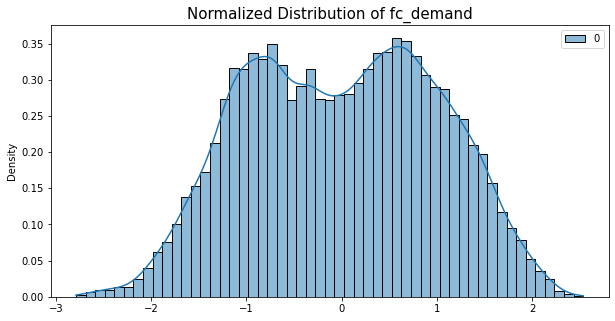

In [32]:
normal_fc_demand = PowerTransformer().fit_transform(df[['fc_demand']])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Normalized Distribution of fc_demand', fontsize=15)
sns.histplot(normal_fc_demand, ax=ax, kde=True, stat='density')

From this normalized distribution, one can see that the variable's range has changed significantly. This can be resolved with a `MinMaxScaler`, to restore this variable to the 0-1 interval.

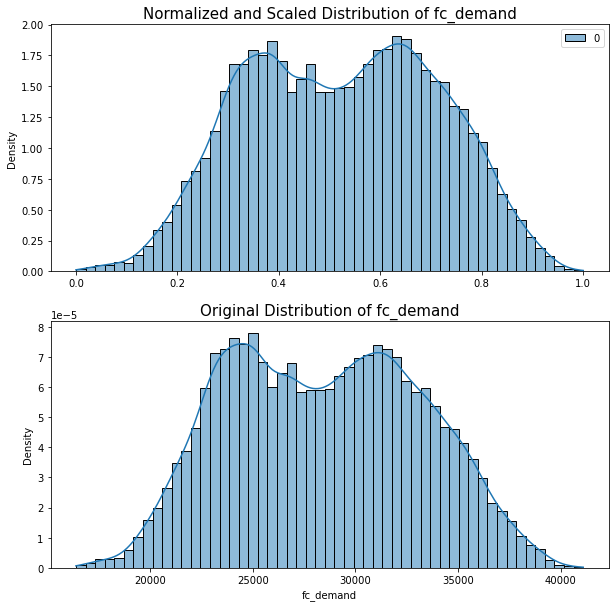

In [33]:
scaled_fc_demand = MinMaxScaler().fit_transform(normal_fc_demand)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of fc_demand', fontsize=15)
sns.histplot(scaled_fc_demand, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of fc_demand', fontsize=15)
sns.histplot(df['fc_demand'], ax=axs[1], kde=True, stat='density')

In [34]:
standard_pipe = Pipeline([('normalizer', PowerTransformer()), ('scaler', MinMaxScaler())])

### 3.3 Cleaning, Normalizing, and Scaling 'import_FR' and 'export_FR'

Before normalizing import_FR and export_FR, we will impute all the missing values with the `mean` of the respective column, as majority of the values are around the average (2nd quartile). Also, the number of missing values are just 13, so replacing by mean won't affect the overall distribution of the graph.

In [35]:
imputed_import = SimpleImputer().fit_transform(df[['import_FR']])
imputed_export = SimpleImputer().fit_transform(df[['export_FR']])

print(f'{sum(np.isnan(imputed_import))[0]} NaNs in import_FR after imputation')
print(f'{sum(np.isnan(imputed_export))[0]} NaNs in export_FR after imputation')

0 NaNs in import_FR after imputation
0 NaNs in export_FR after imputation


#### Normalizing import_FR

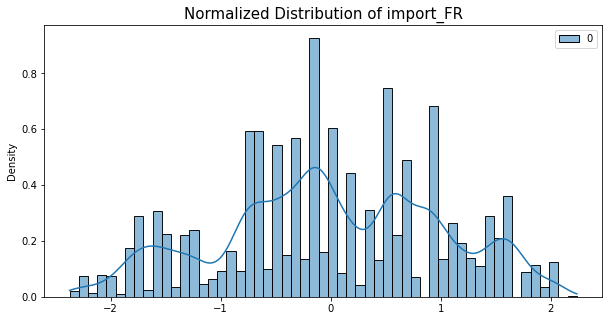

In [36]:
normal_import_FR = PowerTransformer().fit_transform(imputed_import)
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Normalized Distribution of import_FR', fontsize=15)
sns.histplot(normal_import_FR, ax=ax, kde=True, stat='density')

From this normalized distribution, one can see that the variable's range has changed significantly. This can be resolved with a `MinMaxScaler`, to restore this variable to the 0-1 interval.

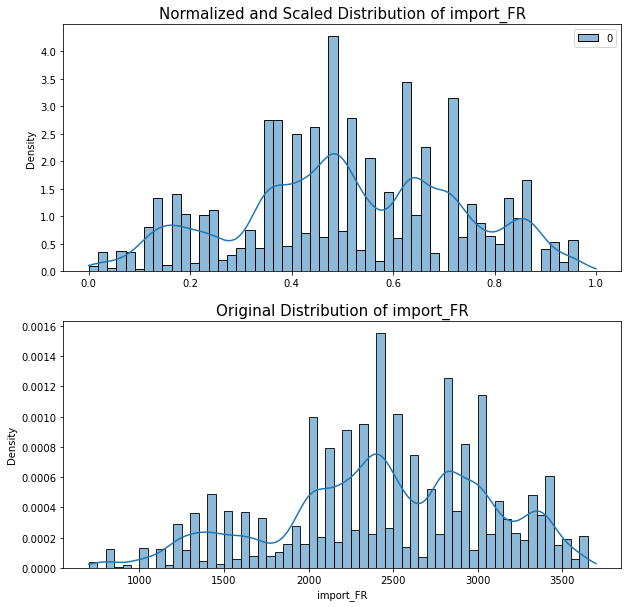

In [37]:
scaled_import_FR = MinMaxScaler().fit_transform(normal_import_FR)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of import_FR', fontsize=15)
sns.histplot(scaled_import_FR, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of import_FR', fontsize=15)
sns.histplot(df['import_FR'].dropna(), ax=axs[1], kde=True, stat='density')

In [38]:
port_FR_pipe = Pipeline([
                        ('imputer', SimpleImputer()), 
                        ('normalizer', PowerTransformer()), 
                        ('scaler', MinMaxScaler())
])

#### Normalizing export_FR

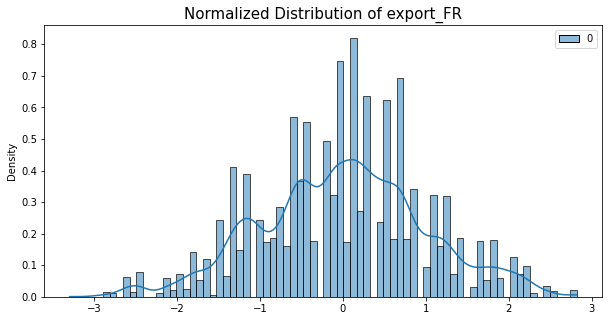

In [39]:
normal_export_FR = PowerTransformer().fit_transform(df[['export_FR']])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Normalized Distribution of export_FR', fontsize=15)
sns.histplot(normal_export_FR, ax=ax, kde=True, stat='density')

From this normalized distribution, one can see that the variable's range has changed significantly. This can be resolved with a `MinMaxScaler`, to restore this variable to the 0-1 interval.

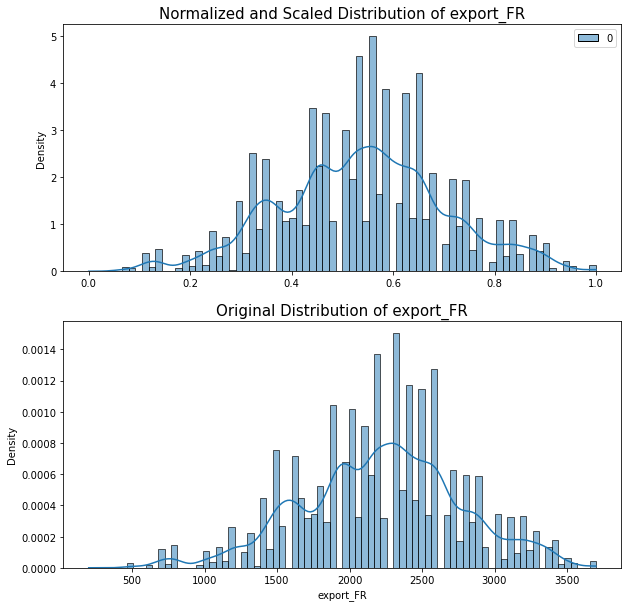

In [40]:
scaled_export_FR = MinMaxScaler().fit_transform(normal_export_FR)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of export_FR', fontsize=15)
sns.histplot(port_FR_pipe.fit_transform(df[['export_FR']]), ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of export_FR', fontsize=15)
sns.histplot(df['export_FR'].dropna(), ax=axs[1], kde=True, stat='density')

### 3.4 Normalizing and Scaling 'fc_wind'

#### 3.4.1 User-defined Function for Scaling with 'fc_demand' 

In [41]:
def scale_with_reference(df, ref_col='fc_demand'):
    """This function takes a DataFrame with two columns, and performs an element-wise division of one column by
    the other. This simple function is meant to be transformed into a scikit-learn FunctionTransformer.
    For the inputs:
    df: DataFrame with two columns
    ref_col: This is the column by which the other column is divided
    """
    
    other = [name for name in df.columns.to_list() if name != ref_col][0]
    scaled_df = df[other] / df[ref_col]
    return scaled_df.to_frame()

In [42]:
fc_wind_scaled = scale_with_reference(df[['fc_wind', 'fc_demand']])
fc_wind_scaled.describe()

,0
count,32135.000000
mean,0.202091
std,0.119741
min,0.004368
25%,0.109573
50%,0.178263
75%,0.274629
max,0.755590


#### 3.4.2 Normalizing after Scaling

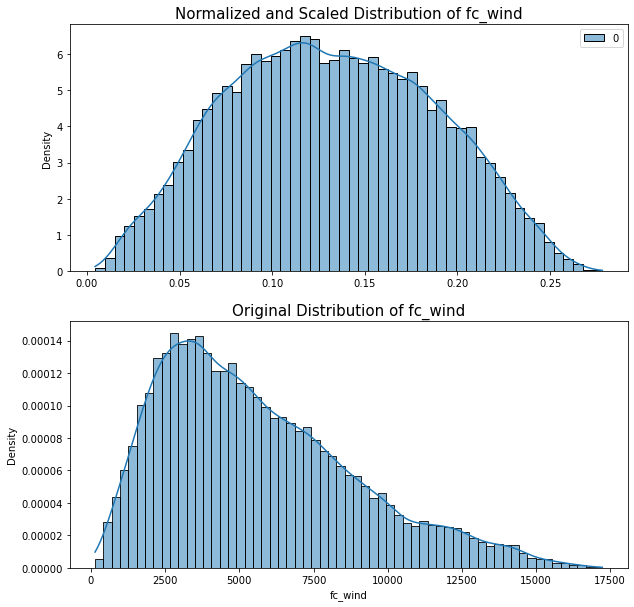

In [43]:
normal_fc_wind = PowerTransformer(standardize=False).fit_transform(fc_wind_scaled)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of fc_wind', fontsize=15)
sns.histplot(normal_fc_wind, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of fc_wind', fontsize=15)
sns.histplot(df['fc_wind'], ax=axs[1], kde=True, stat='density')

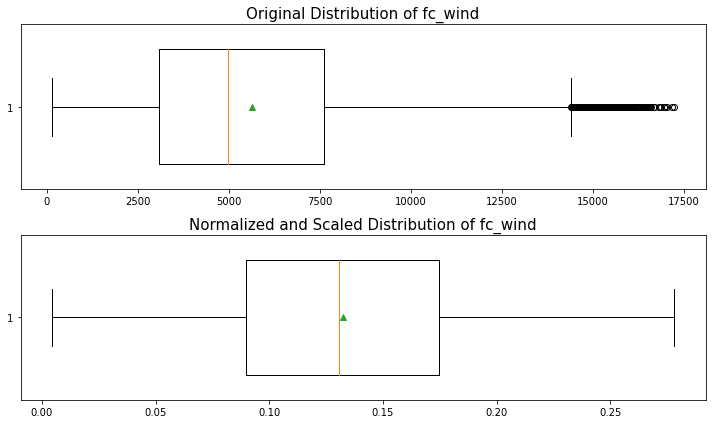

In [44]:
fig, axs = plt.subplots(figsize=(10, 6), ncols=1, nrows=2, sharex=False)
axs[0].set_title('Original Distribution of fc_wind', fontsize=15)
axs[0].boxplot(df['fc_wind'], vert=False, widths=0.7, showmeans=True)

axs[1].set_title('Normalized and Scaled Distribution of fc_wind', fontsize=15)
axs[1].boxplot(normal_fc_wind, vert=False, widths=0.7, showmeans=True)
fig.tight_layout()

#### 3.4.3 Final Pipeline

In [45]:
scale_with_demand_pipe = Pipeline([
                    ('scaler', FunctionTransformer(scale_with_reference)),
                    ('normalizer', PowerTransformer(standardize=False))
])

### 3.5 Normalizing and Scaling 'thermal_gap'

***Thermal Gap is calculated by substracting to the demand the energy provided by nuclear, wind and solar***

In [46]:
df["thermal_gap"] = df["fc_demand"]-(df["fc_nuclear"]+df["fc_wind"]+df["fc_solar_pv"]+df["fc_solar_th"])

In [47]:
thermal_gap_scaled = scale_with_reference(df[['thermal_gap', 'fc_demand']])
thermal_gap_scaled.describe()

,0
count,32135.000000
mean,0.509737
std,0.132102
min,-0.066498
25%,0.429475
50%,0.526975
75%,0.606034
max,0.818801


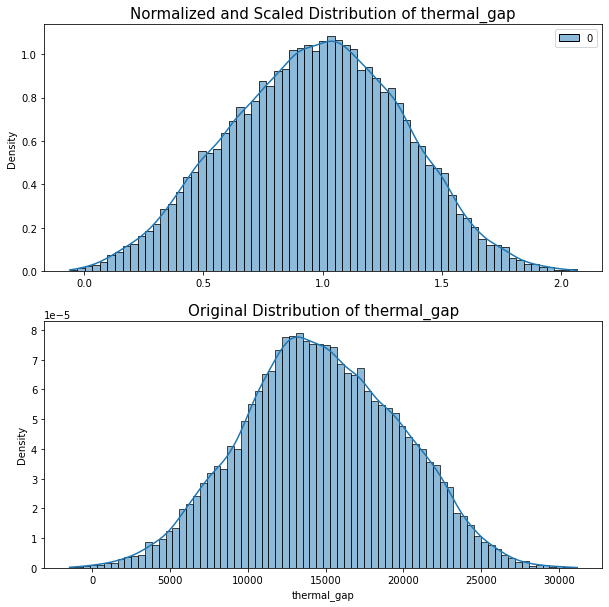

In [48]:
normal_thermal_gap = PowerTransformer(standardize=False).fit_transform(thermal_gap_scaled)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of thermal_gap', fontsize=15)
sns.histplot(normal_thermal_gap, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of thermal_gap', fontsize=15)
sns.histplot(df['thermal_gap'], ax=axs[1], kde=True, stat='density')

### 3.6 Normalizing and Scaling 'fc_nuclear'

In [49]:
scaled_fc_nuclear = scale_with_reference(df[['fc_nuclear', 'fc_demand']])
scaled_fc_nuclear.describe()

,0
count,32135.000000
mean,0.231269
std,0.047943
min,0.113079
25%,0.197841
50%,0.224862
75%,0.263720
max,0.429416


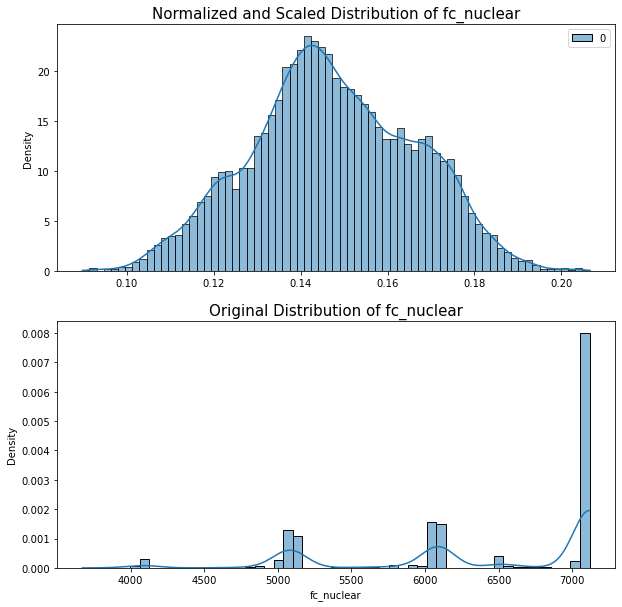

In [50]:
normal_fc_nuclear = PowerTransformer(standardize=False).fit_transform(scaled_fc_nuclear)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of fc_nuclear', fontsize=15)
sns.histplot(normal_fc_nuclear, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of fc_nuclear', fontsize=15)
sns.histplot(df['fc_nuclear'], ax=axs[1], kde=True, stat='density')

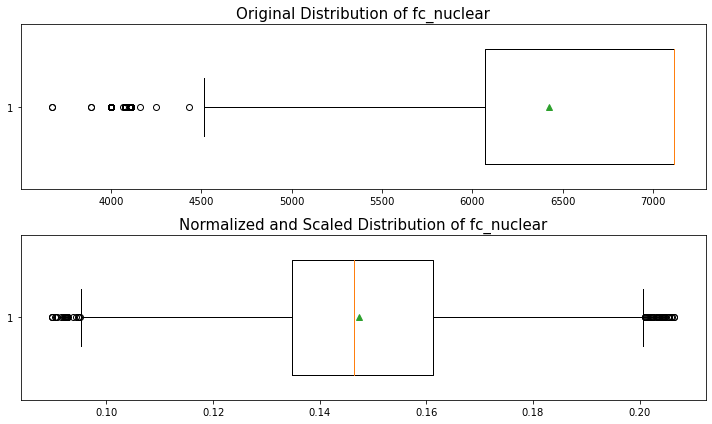

In [51]:
fig, axs = plt.subplots(figsize=(10, 6), ncols=1, nrows=2, sharex=False)
axs[0].set_title('Original Distribution of fc_nuclear', fontsize=15)
axs[0].boxplot(df['fc_nuclear'], vert=False, widths=0.7, showmeans=True)

axs[1].set_title('Normalized and Scaled Distribution of fc_nuclear', fontsize=15)
axs[1].boxplot(normal_fc_nuclear, vert=False, widths=0.7, showmeans=True)
fig.tight_layout()

### 3.7 Encoding 'fc_solar_pv'

In [52]:
scaled_fc_solar_pv = scale_with_reference(df[['fc_solar_pv', 'fc_demand']])
scaled_fc_solar_pv.describe()

,0
count,32135.000000
mean,0.036586
std,0.051239
min,0.000000
25%,0.000000
50%,0.003660
75%,0.068212
max,0.314078


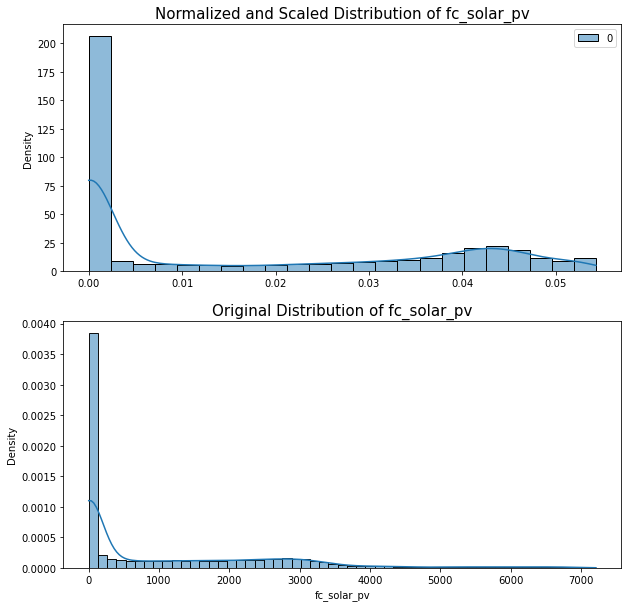

In [53]:
normal_fc_solar_pv = PowerTransformer(standardize=False).fit_transform(scaled_fc_solar_pv)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of fc_solar_pv', fontsize=15)
sns.histplot(normal_fc_solar_pv, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of fc_solar_pv', fontsize=15)
sns.histplot(df['fc_solar_pv'], ax=axs[1], kde=True, stat='density')

**It doesn't make sense to normalise the fc_solar variables as the graph is highly right skewed and maximum number of values are around 0. Hence, we'll create a boolean categorical variable where the values around 0 will be marked a 0, and rest of the values as 1.**

In [54]:
cat_fc_solar_pv = Binarizer().fit_transform(df[['fc_solar_pv']])
print(np.unique(cat_fc_solar_pv, return_counts=True))

(array([0., 1.]), array([13566, 18569], dtype=int64))


### 3.8 Normalizing and Scaling 'fc_solar_th'

In [55]:
scaled_fc_solar_th = scale_with_reference(df[['fc_solar_th', 'fc_demand']])
scaled_fc_solar_th.describe()

,0
count,32135.000000
mean,0.020317
std,0.022487
min,0.000000
25%,0.001162
50%,0.011991
75%,0.031625
max,0.098512


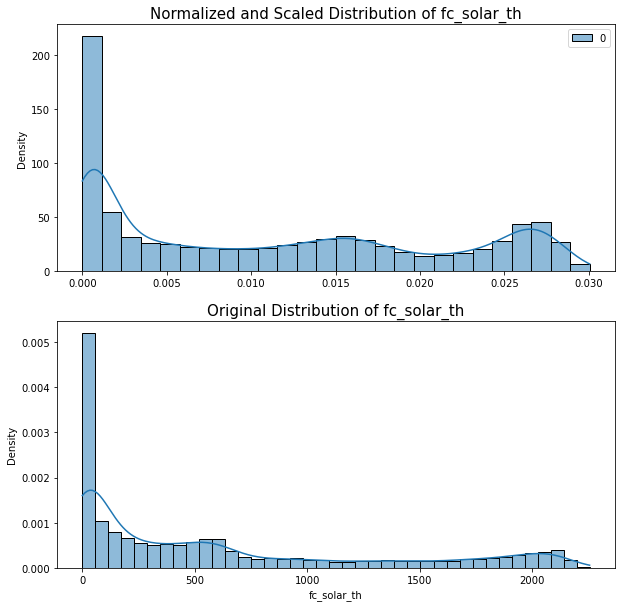

In [56]:
normal_fc_solar_th = PowerTransformer(standardize=False).fit_transform(scaled_fc_solar_th)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of fc_solar_th', fontsize=15)
sns.histplot(normal_fc_solar_th, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of fc_solar_th', fontsize=15)
sns.histplot(df['fc_solar_th'], ax=axs[1], kde=True, stat='density')

### 3.9 Normalizing and Scaling 'price'

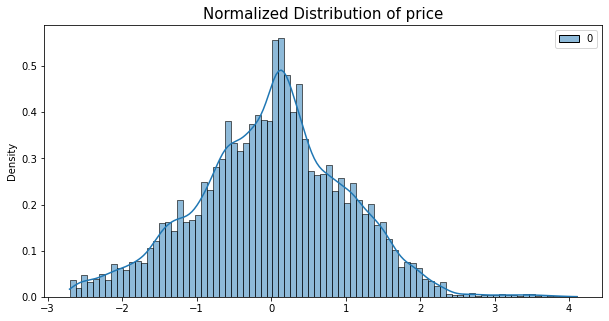

In [57]:
normal_price = PowerTransformer().fit_transform(df[['price']])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title('Normalized Distribution of price', fontsize=15)
sns.histplot(normal_price, ax=ax, kde=True, stat='density')

From this normalized distribution, one can see that the variable's range has changed significantly. This can be resolved with a `MinMaxScaler`, to restore this variable to the 0-1 interval.

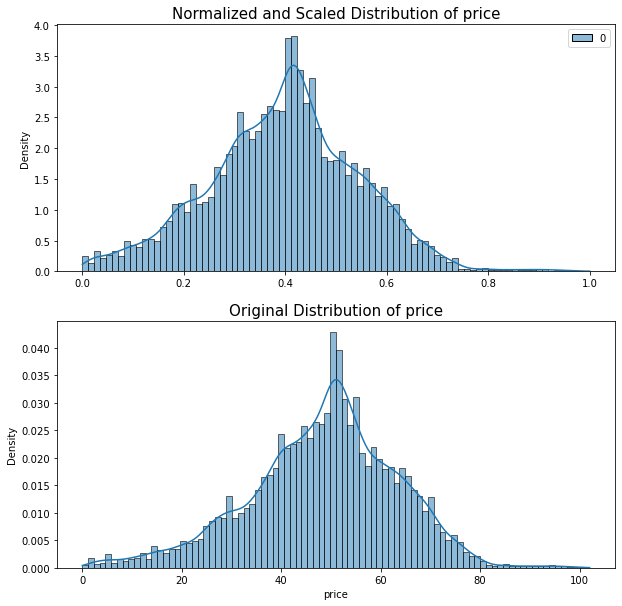

In [58]:
scaled_price = MinMaxScaler().fit_transform(normal_price)
fig, axs = plt.subplots(figsize=(10, 10), nrows=2)
axs[0].set_title('Normalized and Scaled Distribution of price', fontsize=15)
sns.histplot(scaled_price, ax=axs[0], kde=True, stat='density')

axs[1].set_title('Original Distribution of price', fontsize=15)
sns.histplot(df['price'], ax=axs[1], kde=True, stat='density')

### 3.10 Assembling all Preprocessing Steps in a `ColumnTransformer`

#### 3.10.1 Preprocessing with Scaling based on 'demand'

In [59]:
preprocessing_with_demand = ColumnTransformer([
                                        ('demand_transformer', standard_pipe, ['fc_demand']),
                                        ('port_transformer', port_FR_pipe, ['export_FR', 'import_FR']),
                                        ('wind_transformer', scale_with_demand_pipe, ['fc_wind', 'fc_demand']),
                                        ('thermal_transformer', scale_with_demand_pipe, ['thermal_gap', 'fc_demand']),
                                        ('nuclear_transformer', scale_with_demand_pipe, ['fc_nuclear', 'fc_demand']),
                                        ('solar_pv_transformer', Binarizer(), ['fc_solar_pv']),
                                        ('solar_th_transformer', scale_with_demand_pipe, ['fc_solar_th', 'fc_demand']),
                                        ('boolean_passthrough', 'passthrough', 
                                            ['Winter', 'Summer', 'Fall', 'Spring', 'Weekend', 'Holidays', 'Daylight'])
                                        
], remainder='drop')

#### 3.10.2 Preprocessing with Scaling based on `MinMaxScaler`

In [60]:
preprocessing_with_minmax = ColumnTransformer([
                                        ('numeric_transformer', standard_pipe, 
                                             ['fc_demand', 'fc_wind', 'thermal_gap', 'fc_nuclear', 'fc_solar_th']),
                                        ('port_transformer', port_FR_pipe, ['export_FR', 'import_FR']),
                                        ('solar_pv_transformer', Binarizer(), ['fc_solar_pv']),
                                        ('boolean_passthrough', 'passthrough', 
                                            ['Winter', 'Summer', 'Fall', 'Spring', 'Weekend', 'Holidays', 'Daylight'])
                                        
], remainder='drop')

### 3.11 Correlations after Preprocessing

In [61]:
df.columns

Index(['fc_demand', 'fc_nuclear', 'import_FR', 'export_FR', 'fc_wind',
       'fc_solar_pv', 'fc_solar_th', 'price', 'date', 'hour', 'Month',
       'Winter', 'Spring', 'Summer', 'Fall', 'Day_of_Week', 'Weekend', 'day',
       'daymonth', 'Holidays', 'Daylight', 'thermal_gap'],
      dtype='object')

#### 3.11.1 Preprocessing with Scaling based on 'demand'

In [62]:
df_processed = pd.DataFrame(
                            data=preprocessing_with_demand.fit_transform(df),
                            columns=['fc_demand', 'export_FR', 'import_FR', 'fc_wind', 'thermal_gap', 
                                    'fc_nuclear', 'fc_solar_pv', 'fc_solar_th', 'Winter', 'Summer', 
                                     'Fall', 'Spring', 'Weekends', 'Holidays', 'Daylight']
                            )
price_processed = pd.DataFrame(data=standard_pipe.fit_transform(df[['price']]), columns=['price'])
df_processed = pd.concat((df_processed, price_processed), axis=1)

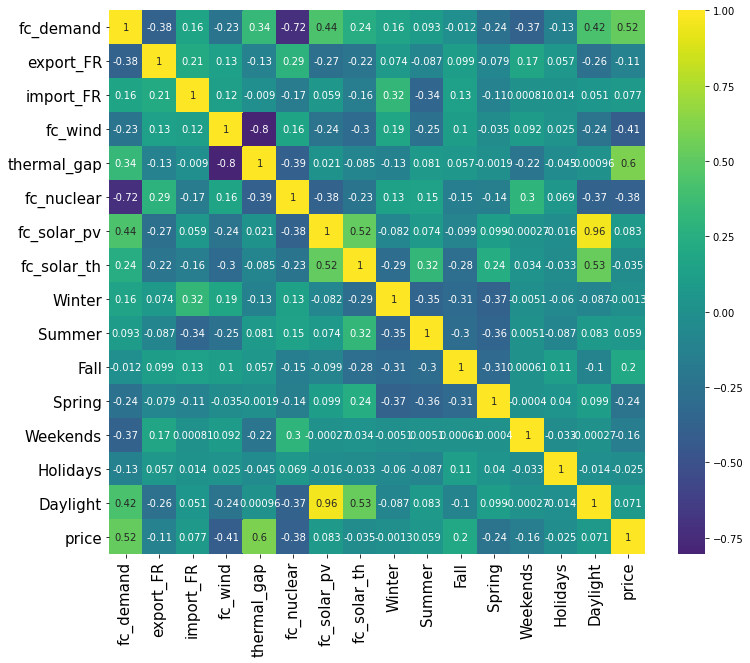

In [63]:
fig, ax = plt.subplots(figsize=(12, 10))
corr_mat = sns.heatmap(df_processed.corr(), annot=True, cmap='viridis', ax=ax, center=0, annot_kws={"fontsize":10})
xtick_labels = corr_mat.get_xmajorticklabels()
ytick_labels = corr_mat.get_ymajorticklabels()
_ = corr_mat.set_xticklabels(xtick_labels, fontsize = 15)
_ = corr_mat.set_yticklabels(ytick_labels, fontsize = 15)

From this correlation matrix, one can extract the following:
* 'fc_demand', 'thermal_gap' are the most positively correlated columns with 'price', whereas 'fc_wind', 'export_FR', 'fc_nuclear', and 'fc_solar_th' show notable negative correlations with 'price'.
* 'Spring', 'Weekends' and 'Holidays' also have a negative correlation with Price.
* 'fc_solar_pv' and 'Holidays' is the best correlation.
* Also, 'fc_solar_pv' and 'fc_solar_th' are very strongly correlated. Perhaps it makes sense to combine both into 'fc_solar', since both energy sources depend strongly on the amount of sunlight and hence each of them have a very strong correlation with Daylight. However, 'fc_solar_pv' has a stronger relation with 'price' than its thermal counterpart.

#### 3.11.2 Preprocessing with Scaling based on `MinMaxScaler``

In [64]:
df_processed = pd.DataFrame(
                            data=preprocessing_with_minmax.fit_transform(df),
                            columns=['fc_demand', 'fc_wind', 'thermal_gap', 'fc_nuclear', 'fc_solar_th',
                                     'export_FR', 'import_FR', 'fc_solar_pv', 'Winter', 'Summer', 
                                     'Fall', 'Spring', 'Weekends', 'Holidays', 'Daylight']
                            )
price_processed = pd.DataFrame(data=standard_pipe.fit_transform(df[['price']]), columns=['price'])
df_processed = pd.concat((df_processed, price_processed), axis=1)

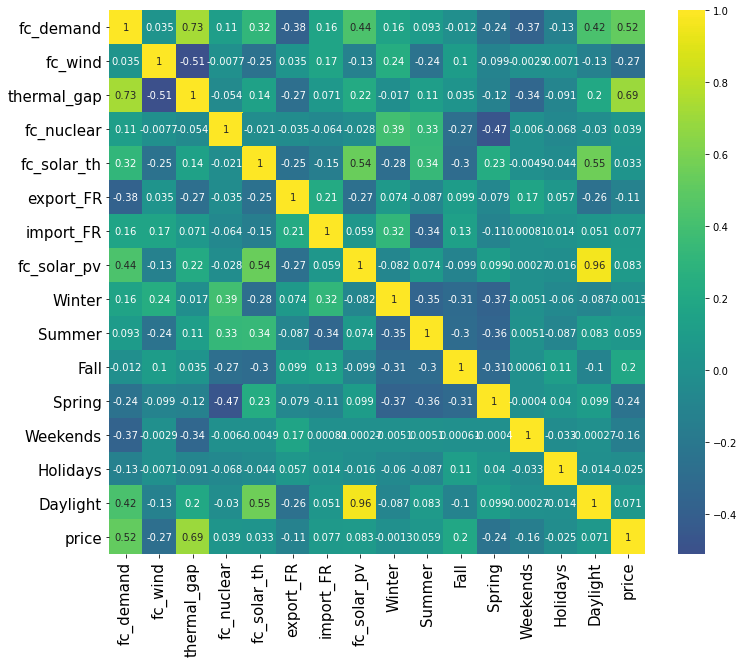

In [65]:
fig, ax = plt.subplots(figsize=(12, 10))
corr_mat = sns.heatmap(df_processed.corr(), annot=True, cmap='viridis', ax=ax, center=0, annot_kws={"fontsize":10})
xtick_labels = corr_mat.get_xmajorticklabels()
ytick_labels = corr_mat.get_ymajorticklabels()
_ = corr_mat.set_xticklabels(xtick_labels, fontsize = 15)
_ = corr_mat.set_yticklabels(ytick_labels, fontsize = 15)

As is visible, even with all these feature engineering steps, there is a very large number of features whose correlation with 'price', the target to be classified, is fairly insignificant. Thus, a good model will only be achievable as long as these irrelevant features are not taken into account in the training of the model. 

In the following section, a set of basic algorithms will be employed for a preliminary classification of the processed dataset. As a result of these classifications, it will be possible to directly identify what variables do not contribute to improve the model's prediction. It is helpful to perform this extra step since the correlation may only indicate the strength of a potential linear relationship between target and feature, whereas a feature's importance to a non-linear predictor gives a more direct measure of its relevance to this study. 

Based on the features that are identified as relevant to the prediction, it is possible to perform a thorough parameter search to determine the best model and the best hyperparameters with which to apply it.

## 4. Choosing and Training a Model

In [66]:
standard_pipe.fit_transform(df[['price']])

array([[0.49896374],
       [0.49266489],
       [0.42671108],
       ...,
       [0.46574576],
       [0.41454911],
       [0.3561959 ]])

### 4.1 Splitting into Training and Test Datasets

The splitting of the dataset carried out here is used in order to preliminarly explore the performance of a series of simple models. For later optimizations, a proper cross-validation is employed.

The size of the evaluation set in this case is set to be similar to that of the evaluation set in `scoring.csv`. It seems relevant to compare this evaluation set with the size of the DataFrame used to fit the model.

In [67]:
scoring_size = len(pd.read_csv('scoring.csv', parse_dates=['date']))
print(f'scoring.csv contains {scoring_size} entries. That is {scoring_size * 100 / len(df):.3f}% of df')

scoring.csv contains 3673 entries. That is 11.430% of df


Special care has to be taken with the transformation applied to y. Since later on, the predictions to `scoring.csv` will be obtained, it is necessary to undo the transformations initially applied to y, in order to upload price data that has a reasonable distribution and units.

In [68]:
df_train = df.iloc[:-scoring_size, :]
X_train = df_train.drop(columns='price')
y_train = standard_pipe.fit_transform(df_train[['price']])

df_test = df.iloc[-scoring_size:, :]
X_test = df_test.drop(columns='price')
y_test = standard_pipe.fit_transform(df_test[['price']])

X = df.drop(columns='price')
y = standard_pipe.fit_transform(df[['price']])

pipe_for_y = standard_pipe.fit(df[['price']])

### 4.2 Simple Linear Regression
Let's start this prediction with a simple linear regression.

In [69]:
clf_1 = Pipeline([
    ('preprocessing', preprocessing_with_minmax),
    ('regressor', LinearRegression())
])

In [70]:
clf_1.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['export_FR', 'import_FR']),
                                                 ('solar_pv_transformer',
                                                  Binarizer(),
                                                  ['fc_solar_pv']),
                                                 ('boolean_passthrough',
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('regressor', LinearRegression())])

In [71]:
y_pred1 = clf_1.predict(X_test)
print(f'Linear Regression: R2 = {r2_score(y_test, y_pred1):.4f}')

Linear Regression: R2 = 0.1149


#### 4.2.1 Feature Importance

Improve final model by using only top 3 most significant features. It has been seen that using all features does not result in the best model.

In [72]:
features=['fc_demand', 'fc_wind', 'thermal_gap', 'fc_nuclear', 'fc_solar_th',
                                     'export_FR', 'import_FR', 'fc_solar_pv', 'Winter', 'Summer', 
                                     'Fall', 'Spring', 'Weekends', 'Holidays', 'Daylight']
importances = np.abs(clf_1['regressor'].coef_)

In [73]:
top3_reg1 = np.ravel(np.argsort(importances))[:-5:-1]
[features[i] for i in np.ravel(np.argsort(importances))[::-1]]

['thermal_gap',
 'fc_wind',
 'fc_demand',
 'fc_nuclear',
 'fc_solar_th',
 'export_FR',
 'Fall',
 'Winter',
 'Weekends',
 'fc_solar_pv',
 'Holidays',
 'Daylight',
 'Summer',
 'import_FR',
 'Spring']

### 4.3 k-NN Regression
Now, to another simple model: k-nearest neighbors for regression. Note how simple it is to implement these models with scikit-learn.

In [74]:
clf_2 = Pipeline([
    ('preprocessing', preprocessing_with_minmax),
    ('regressor', KNeighborsRegressor())
])

In [75]:
clf_2.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['export_FR', 'import_FR']),
                                                 ('solar_pv_transformer',
                                                  Binarizer(),
                                                  ['fc_solar_pv']),
                                                 ('boolean_passthrough',
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('regressor', KNeighborsRegressor())])

In [76]:
y_pred2 = clf_2.predict(X_test)
print(f'k-NN Regression: R2 = {r2_score(y_test, y_pred2):.4f}')

k-NN Regression: R2 = 0.2330


### 4.4 Random Forest Regression
Now let's shift to more complex models, such as this random forest regressor. It is expected to better capute the non-linear relationships within the dataset.

In [77]:
clf_3 = Pipeline([
    ('preprocessing', preprocessing_with_minmax),
    ('regressor', RandomForestRegressor(n_jobs=-1))
])

In [78]:
clf_3.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['export_FR', 'import_FR']),
                                                 ('solar_pv_transformer',
                                                  Binarizer(),
                                                  ['fc_solar_pv']),
                                                 ('boolean_passthrough',
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('regressor', RandomForestRegressor(n_jobs=-1))])

In [79]:
y_pred3 = clf_3.predict(X_test)
print(f'Random Forest Regression: R2 = {r2_score(y_test, y_pred3):.4f}')

Random Forest Regression: R2 = 0.3159


#### 4.4.1 Feature Importance

In [80]:
importances = clf_3['regressor'].feature_importances_

In [81]:
top3_reg3 = np.ravel(np.argsort(importances))[:-5:-1]
[features[i] for i in np.ravel(np.argsort(importances))[::-1]]

['thermal_gap',
 'import_FR',
 'export_FR',
 'fc_nuclear',
 'fc_wind',
 'fc_demand',
 'fc_solar_th',
 'Winter',
 'fc_demand',
 'Fall',
 'Summer',
 'Spring',
 'Weekends',
 'Holidays',
 'fc_solar_pv',
 'Daylight']

### 4.5 Gradient Boosting Regression
The last regressor to be attempted in this study is `GradientBoostingRegressor`. This algorithm is also expected to take into account the non-linearities of the dataset.

In [82]:
clf_4 = Pipeline([
    ('preprocessing', preprocessing_with_minmax),
    ('regressor', GradientBoostingRegressor())
])

In [83]:
clf_4.fit(X_train, np.ravel(y_train))

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['export_FR', 'import_FR']),
                                                 ('solar_pv_transformer',
                                                  Binarizer(),
                                                  ['fc_solar_pv']),
                                                 ('boolean_passthrough',
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('regressor', GradientBoostingRegressor())])

In [84]:
y_pred4 = clf_4.predict(X_test)
print(f'Gradient Boosting Regressor: R2 = {r2_score(y_test, y_pred4):.4f}')

Gradient Boosting Regressor: R2 = 0.2521


#### 4.5.1 Feature Importance

In [85]:
importances = clf_4['regressor'].feature_importances_
top3_reg4 = np.ravel(np.argsort(importances))[:-5:-1]
[features[i] for i in np.ravel(np.argsort(importances))[::-1]]

['thermal_gap',
 'import_FR',
 'export_FR',
 'fc_nuclear',
 'Fall',
 'Winter',
 'fc_demand',
 'fc_solar_th',
 'fc_wind',
 'Summer',
 'Weekends',
 'Holidays',
 'Daylight',
 'Spring',
 'fc_solar_pv']

### 4.6 Hyperparameter Tuning and Model Selection

In order to select the best model with the most appropriate set of parameters, we will now make use of scikit-learn's `GridSearchCV`, with a custom cross validation scheme. Since our data is a time series it is important to use use `sklearn.model_selection.TimeSeriesSplit` for cross-validation. The test size for this `TimeSeriesSplit` is set to be similar to the test dataset from `scoring.csv`. Moreover, in order to impose a rolling scheme when selecting the training dataset at each fold (as opposed to a fully recursive scheme), the max train size is set such that at every fold of the cross-validation, there is an 80-20 split between training and test sets.

In [86]:
tscv = TimeSeriesSplit(n_splits=5, test_size=scoring_size, max_train_size=int(scoring_size / 0.8))
print(tscv)

TimeSeriesSplit(gap=0, max_train_size=4591, n_splits=5, test_size=3673)


Let's use only the most significant features to train this model.

In [87]:
significant_features = np.union1d(top3_reg1, np.union1d(top3_reg3, top3_reg4))
feature_selector = ColumnTransformer([('significant_passthrough', 'passthrough', significant_features)], remainder='drop')

In [88]:
clf = Pipeline([
                ('preprocessing', preprocessing_with_minmax),
                ('feature_selector', feature_selector),
                ('decomposition', PCA(n_components='mle')),
                ('regressor', RandomForestRegressor())
])

The following model and parameter combinations will be tested:
* `KNeighborsRegressor` with varying n_neighbors and the p defining the Minkowski distance.
* `RandomForestRegressor` with varying n_estimators, maximum depth, and minimum samples to split an internal node.
* `GradientBoostingRegressor` with varying learning rate, number of estimators, and number of iterations for early stopping

In [89]:
param_grid = [
    {"regressor": [RandomForestRegressor(n_jobs=-1)],
     "regressor__max_depth": [10, 25],
     "regressor__min_samples_split": [2, 10],
     "regressor__max_features": ['auto', 'sqrt'],
     'preprocessing': [preprocessing_with_demand, preprocessing_with_minmax],
     'decomposition': ['passthrough', PCA(n_components='mle')]},
    
    {"regressor": [GradientBoostingRegressor(n_iter_no_change=30)],
     "regressor__learning_rate": [0.05, 0.5],
     "regressor__n_estimators": [75, 150],
     "regressor__max_features": [None, 0.5, 0.7],
     'preprocessing': [preprocessing_with_demand, preprocessing_with_minmax],
     'decomposition': ['passthrough', PCA(n_components='mle')]}
]

To carry out this grid search properly, we use the RMSE as a scoring measure, since that is how the resulting prediction with `scoring.csv` will be evaluated.

In [90]:
gs = GridSearchCV(clf, 
                  param_grid, 
                  cv=tscv, 
                  scoring='neg_root_mean_squared_error', 
                  refit=True,
                  n_jobs=-1, 
                  verbose=3)

In [91]:
gs.fit(X, np.ravel(y))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=4591, n_splits=5, test_size=3673),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('numeric_transformer',
                                                                         Pipeline(steps=[('normalizer',
                                                                                          PowerTransformer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['fc_demand',
                                                                          'fc_wind',
                                                                          'thermal_gap',
                                                                          'fc_nuclear',
                                                                          'fc_solar_th']),
                                                                        ('port_transformer',
                                                                         Pip...
                                                                             'passthrough',
                                                                             ['Winter',
                                                                              'Summer',
                                                                              'Fall',
                                                                              'Spring',
                                                                              'Weekend',
                                                                              'Holidays',
                                                                              'Daylight'])])],
                          'regressor': [GradientBoostingRegressor(learning_rate=0.05,
                                                                  max_features=0.7,
                                                                  n_estimators=75,
                                                                  n_iter_no_change=30)],
                          'regressor__learning_rate': [0.05, 0.5],
                          'regressor__max_features': [None, 0.5, 0.7],
                          'regressor__n_estimators': [75, 150]}],
             scoring='neg_root_mean_squared_error', verbose=3)

In [92]:
gs.cv_results_

{'mean_fit_time': array([1.67625871, 1.55755963, 0.97281308, 0.89487267, 2.20492072,
        1.81061168, 1.26557584, 1.022123  , 1.46219954, 1.53536682,
        0.9327805 , 0.89336224, 2.00839782, 1.89331985, 1.28801627,
        0.95364156, 1.77877598, 1.74470758, 1.22526007, 1.05909638,
        2.4106319 , 2.2950861 , 1.59282618, 1.22916617, 1.90611577,
        1.82195911, 1.10931525, 0.99296904, 2.34185944, 2.43310246,
        2.00976744, 1.61174641, 1.14948449, 1.45397367, 0.49993219,
        0.82143445, 0.52873516, 0.87804718, 0.82569537, 1.22798557,
        0.75268731, 0.74137092, 0.85181537, 0.57493472, 0.93786869,
        1.49759326, 0.61852026, 0.95305381, 0.58131161, 1.00538721,
        0.88370128, 0.86052079, 0.66566281, 0.70942183, 0.60652699,
        0.47407427, 1.11549749, 1.82321997, 0.471206  , 0.91390395,
        0.59218135, 0.9243988 , 0.76020823, 0.71470499, 0.53510809,
        0.92682228, 0.71982117, 0.58664975, 0.83904157, 1.32266331,
        0.45901823, 0.72612453,

Once `GridSearchCV`attempts all the model and hyperparameter combinations specified above, it determines what the best configuration is. Then, since `refit=True`, a model with this optimum configuration is fitted with the whole dataset (without any train-test splitting), and obtains with it the `best_estimator_`. However, this optimal configuration is used to compute a mean mean cross-validated score `best_score_`, which is presented below. 

In [93]:
print(f'Best Regressor: RMSE = {-gs.best_score_:.4f}')

Best Regressor: RMSE = 0.1137


In [94]:
gs.best_params_

{'decomposition': 'passthrough',
 'preprocessing': ColumnTransformer(transformers=[('numeric_transformer',
                                  Pipeline(steps=[('normalizer',
                                                   PowerTransformer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['fc_demand', 'fc_wind', 'thermal_gap',
                                   'fc_nuclear', 'fc_solar_th']),
                                 ('port_transformer',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('normalizer',
                                                   PowerTransformer()),
                                                  ('scaler', MinMaxScaler())]),
                                  ['export_FR', 'import_FR']),
                                 ('solar_pv_transformer', Binarizer(),
                                  ['fc_solar_pv']),

In [95]:
gs.best_estimator_

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScal...
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('feature_selector',
                 ColumnTransformer(transformers=[('significant_passthrough',
                                                  'passthrough',
                                                  array([0, 1, 2, 3, 5, 6]))])),
                ('decomposition', 'passthrough'),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_features=0.7,
                                           n_estimators=75,
                                           n_iter_no_change=30))])

In [96]:
clf = gs.best_estimator_

### 4.7 Further Tuning for `GradientBoostingRegressor`
#### 4.7.1 Tuning `n_estimators`

In [97]:
n_estimators = np.arange(50, 175, 10)
train_scores, test_scores = validation_curve(clf, 
                                             X, 
                                             np.ravel(y), 
                                             cv=tscv, 
                                             param_name="regressor__n_estimators", 
                                             param_range=n_estimators, scoring='neg_root_mean_squared_error',
                                             n_jobs=-1)

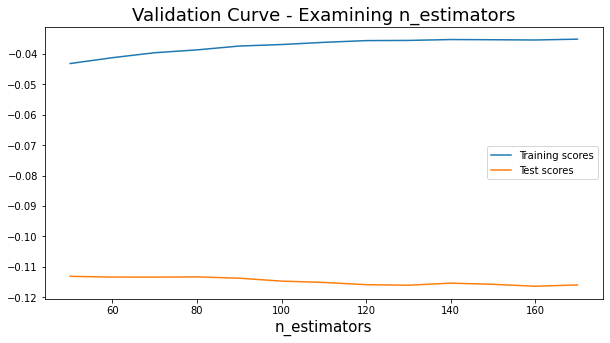

In [98]:
plt.figure(figsize=(10,5))
plt.title('Validation Curve - Examining n_estimators', fontsize=18)
plt.plot(n_estimators, np.mean(train_scores, axis=1), label='Training scores')
plt.plot(n_estimators, np.mean(test_scores, axis=1), label='Test scores')
plt.xlabel('n_estimators', fontsize=15)
plt.legend()

#### 4.7.2 Tuning `learning_rate`

In [99]:
learning_rate = np.logspace(-2, -0.5, 10)
train_scores, test_scores = validation_curve(clf, 
                                             X, 
                                             np.ravel(y), 
                                             cv=tscv, 
                                             param_name="regressor__learning_rate", 
                                             param_range=learning_rate, scoring='neg_root_mean_squared_error',
                                             n_jobs=-1)

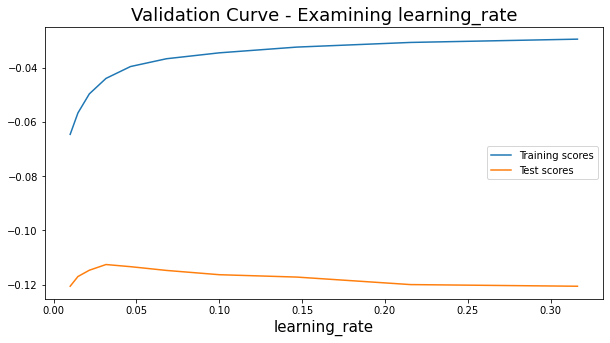

In [100]:
plt.figure(figsize=(10,5))
plt.title('Validation Curve - Examining learning_rate', fontsize=18)
plt.plot(learning_rate, np.mean(train_scores, axis=1), label='Training scores')
plt.plot(learning_rate, np.mean(test_scores, axis=1), label='Test scores')
plt.xlabel('learning_rate', fontsize=15)
plt.legend()

#### 4.7.3 Tuning `max_features`

In [101]:
max_features = np.arange(1, 7)
train_scores, test_scores = validation_curve(clf, 
                                             X, 
                                             np.ravel(y), 
                                             cv=tscv, 
                                             param_name="regressor__max_features", 
                                             param_range=max_features, 
                                             scoring='neg_root_mean_squared_error',
                                             n_jobs=-1)

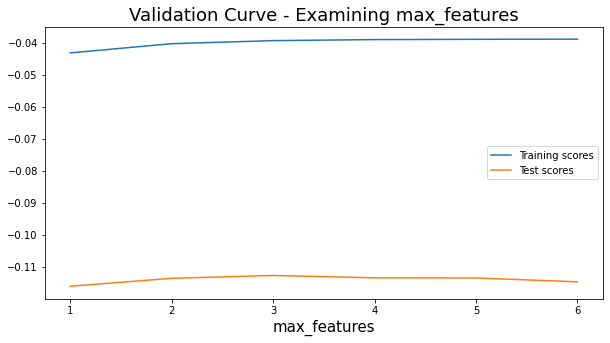

In [102]:
plt.figure(figsize=(10,5))
plt.title('Validation Curve - Examining max_features', fontsize=18)
plt.plot(max_features, np.mean(train_scores, axis=1), label='Training scores')
plt.plot(max_features, np.mean(test_scores, axis=1), label='Test scores')
plt.xlabel('max_features', fontsize=15)
plt.legend()

#### 4.7.4 Tuning the Train Size

In [103]:
train_sizes = np.linspace(0.1, 0.8, 20)
_, train_scores, test_scores = learning_curve(clf, 
                                           X, 
                                           np.ravel(y), 
                                           train_sizes=train_sizes, 
                                           cv=tscv, 
                                           scoring='neg_root_mean_squared_error', 
                                           n_jobs=-1)

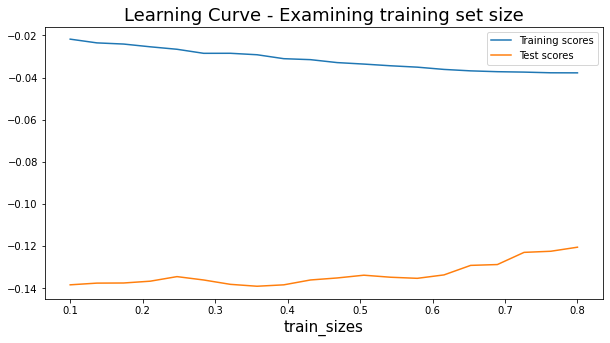

In [104]:
plt.figure(figsize=(10,5))
plt.title('Learning Curve - Examining training set size', fontsize=18)
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training scores')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test scores')
plt.xlabel('train_sizes', fontsize=15)
plt.legend()

### 4.8 Prediction with the Optimum Regressor

In [105]:
optimal_params = {
                'regressor__learning_rate': 0.05, 
                'regressor__n_estimators': 80,
                'regressor__n_iter_no_change': 30
}
clf.set_params(**optimal_params)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['fc_demand', 'fc_wind',
                                                   'thermal_gap', 'fc_nuclear',
                                                   'fc_solar_th']),
                                                 ('port_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('normalizer',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   MinMaxScal...
                                                  'passthrough',
                                                  ['Winter', 'Summer', 'Fall',
                                                   'Spring', 'Weekend',
                                                   'Holidays', 'Daylight'])])),
                ('feature_selector',
                 ColumnTransformer(transformers=[('significant_passthrough',
                                                  'passthrough',
                                                  array([0, 1, 2, 3, 5, 6]))])),
                ('decomposition', 'passthrough'),
                ('regressor',
                 GradientBoostingRegressor(learning_rate=0.05, max_features=0.7,
                                           n_estimators=80,
                                           n_iter_no_change=30))])

The scores shown below can be used as a fairly optimistic reference, since the model `clf` has been trained with the whole dataset, based on the optimum parameter configuration obtained with `GridSearchCV`. Therefore, scoring how a model predicts its own training set will always yield larger scores than the ones expected when this model is extrapolated to other evaluation sets. In any case, this allows one to view a fairly overvalued estimate of other scoring measures not taken into account in the previous grid search, such as R2, which is shown below.

In [106]:
y_pred = clf.predict(X)
print(f'Best Regressor: R2 = {r2_score(y, y_pred):.4f}')

Best Regressor: R2 = 0.6047


In [107]:
print(f'Best Regressor: RMSE = {mean_squared_error(y, y_pred, squared=False):.4f}')

Best Regressor: RMSE = 0.0923


In [108]:
importances = clf['regressor'].feature_importances_
[features[i] for i in np.ravel(np.argsort(importances))[::-1]]

['thermal_gap',
 'export_FR',
 'fc_demand',
 'fc_solar_th',
 'fc_nuclear',
 'fc_wind']

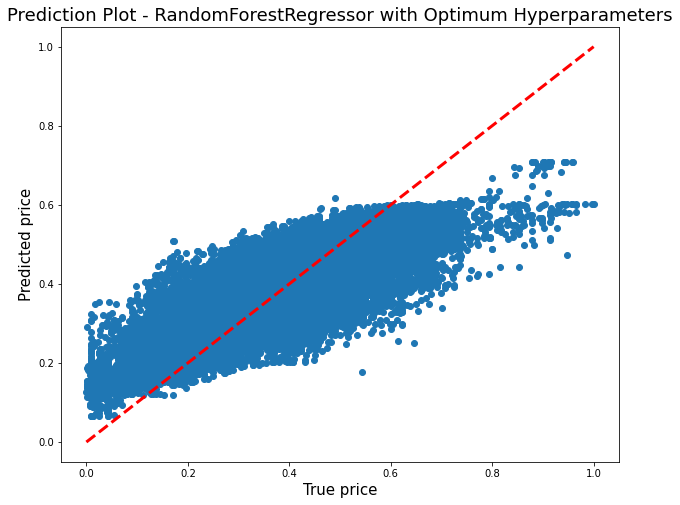

In [109]:
plt.figure(figsize=(10,8))
plt.title('Prediction Plot - RandomForestRegressor with Optimum Hyperparameters', fontsize=18)
plt.scatter(y, y_pred)
diagonal = np.linspace(min(np.min(y), np.min(y_pred)), max(np.max(y_test), np.max(y_pred)))
plt.plot(diagonal, diagonal, 'r--', linewidth=3)
plt.xlabel('True price', fontsize=15)
plt.ylabel('Predicted price', fontsize=15)
plt.show()

## 5. Predicting with `scoring.csv`

### 5.1 Importing the Evaluation Set

In [110]:
df_score = pd.read_csv('scoring.csv', parse_dates=['date'])
df_score.head()

,fc_demand,fc_nuclear,import_FR,export_FR,fc_wind,fc_solar_pv,fc_solar_th,date,hour
0,24744.0,7117.2,2300.0,1750.0,2751.0,0.0,627.1,2020-09-01,0
1,23426.0,7117.2,2300.0,2100.0,2452.0,0.0,606.6,2020-09-01,1
2,22597.0,7117.2,2300.0,2100.0,2060.0,0.0,528.3,2020-09-01,2
3,22285.0,7117.2,2300.0,2100.0,1736.0,0.0,598.5,2020-09-01,3
4,22192.0,7117.2,2300.0,2100.0,1322.0,0.0,474.9,2020-09-01,4


### 5.2 Processing and Predicting the Evaluation Set

In [111]:
df_score = generate_features_from_time(df_score)
df_score["thermal_gap"] = df_score["fc_demand"]-(df_score["fc_nuclear"]+df_score["fc_wind"]+df_score["fc_solar_pv"]+df_score["fc_solar_th"])

y_score = clf.predict(df_score)

### 5.3 Undoing Transformations and Saving Predictions

In [112]:
#standard_pipe = Pipeline([('normalizer', PowerTransformer()), ('scaler', MinMaxScaler())])
y_score_inverse = pipe_for_y['scaler'].inverse_transform(np.reshape(y_score, (-1, 1)))
y_score_inverse = pipe_for_y['normalizer'].inverse_transform(np.reshape(y_score_inverse, (-1, 1)))
np.savetxt('prediction.csv', y_score_inverse, delimiter=',')

## 6. Conclusions and Further Work